# AE / VAE / CVAE


## imports and load data

In [24]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn

PATH = 'data'
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
# MOMENTUM = 0.9
EPOCHS = 50
LATENT_DIM = 2

# modules = dir(torch)
# print(modules)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = torchvision.transforms.ToTensor()

train_data = torchvision.datasets.MNIST(root=PATH, train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root=PATH, train=False, download=True, transform=transform)

## DataLoader

In [2]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

## check data

torch.Size([1, 28, 28])
minvalue, maxvalue: 0.0, 1.0


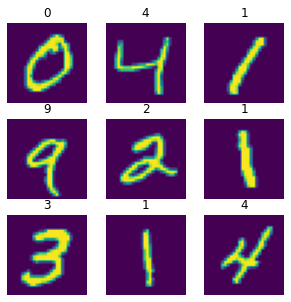

In [3]:
bild, _ = train_data[0]
print(bild.shape)
print(f'minvalue, maxvalue: {torch.min(bild).item()}, {torch.max(bild).item()}')

fig = plt.figure(figsize=(5, 5))
rows, col = 3, 3

for i in range(1, rows*col +1):
    im, label = train_data[i]
    fig.add_subplot(rows, col, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(im.squeeze())
plt.show()

# Autoencoder 

## Encoder, Decoder and Autoencoder classes

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32*7*7, 2 * self.latent_dim)
        self.fc2 = nn.Linear(2 * self.latent_dim, self.latent_dim)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 32*7*7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()

        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 2 * self.latent_dim)
        self.fc2 = nn.Linear(2 * self.latent_dim, 32*7*7)
        self.bn_fc = nn.BatchNorm2d(32)
        
        self.t_conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.t_conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, padding=0, stride=2)
        self.bn2 = nn.BatchNorm2d(1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.fc1(input)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.view(-1, 32, 7, 7)
        #x = self.bn_fc(x)
        x = self.relu(x)
        
        x = self.t_conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)

        x = self.t_conv2(x)
        #x = self.bn2(x)
        x = self.sigmoid(x)


        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def forward(self, input): 
        
        x = self.encoder(input)
        x = self.decoder(x)
        return x

## check that classes are working correctly

(28, 28)


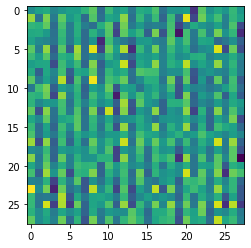

In [25]:
autoencoder = Autoencoder(LATENT_DIM)
autoencoder = autoencoder.to(device)

im, _ = train_data[0]
im = im.to(device)

y = autoencoder(im.unsqueeze(0))

pix = y.squeeze().cpu().detach().numpy()

print(pix.shape)
plt.imshow(pix)
plt.show()

## define model / set up loss and optimizer $\circ $ **model**

In [6]:
model = Autoencoder(LATENT_DIM)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# print(model)

## training

In [7]:
#training_loss = []
print('starting training...')

for epoch in range(EPOCHS): 
    
    epoch_loss = 0.0 
    for batch in train_dataloader:
        im, _ = batch
        im = im.to(device)
        
        output = model(im)
        
        loss = criterion(im, output)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss.item()*im.size(0)
    
    epoch_loss = epoch_loss / len(train_dataloader)
    #training_loss.append(epoch_loss)
    print(f'epoch {epoch+1} loss: {epoch_loss:.3f}')

starting training...
epoch 1 loss: 23.858
epoch 2 loss: 16.442
epoch 3 loss: 16.191
epoch 4 loss: 16.040
epoch 5 loss: 15.902
epoch 6 loss: 15.763
epoch 7 loss: 15.639
epoch 8 loss: 15.534
epoch 9 loss: 15.437
epoch 10 loss: 15.350
epoch 11 loss: 15.272
epoch 12 loss: 15.194
epoch 13 loss: 15.117
epoch 14 loss: 15.048
epoch 15 loss: 14.967
epoch 16 loss: 14.905
epoch 17 loss: 14.857
epoch 18 loss: 14.811
epoch 19 loss: 14.767
epoch 20 loss: 14.727
epoch 21 loss: 14.685
epoch 22 loss: 14.644
epoch 23 loss: 14.605
epoch 24 loss: 14.564
epoch 25 loss: 14.523
epoch 26 loss: 14.482
epoch 27 loss: 14.443
epoch 28 loss: 14.401
epoch 29 loss: 14.358
epoch 30 loss: 14.320
epoch 31 loss: 14.286
epoch 32 loss: 14.253
epoch 33 loss: 14.218
epoch 34 loss: 14.180
epoch 35 loss: 14.148
epoch 36 loss: 14.117
epoch 37 loss: 14.091
epoch 38 loss: 14.067
epoch 39 loss: 14.044
epoch 40 loss: 14.022
epoch 41 loss: 13.999
epoch 42 loss: 13.976
epoch 43 loss: 13.953
epoch 44 loss: 13.934
epoch 45 loss: 13.91

## testing the trained model

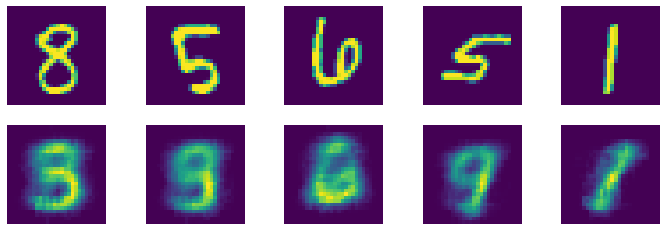

In [8]:
# im, label = test_data[0]
# im = im.to(device)

# y = model(im.unsqueeze(0))
# pix = y.squeeze().cpu().detach().numpy()
# im = im.squeeze().cpu().detach().numpy()

# fig, (ax1, ax2) = plt.subplots(2, 5)
# ax1.imshow(im)
# ax1.axis('off')
# ax2.imshow(pix)
# ax2.axis('off')
# plt.show()

fig, axa = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,4))

for j in range(5): 
    pix = []
    im, _ = test_data[np.random.randint(0, len(test_data))]
    pix.append(im.squeeze().cpu().detach().numpy())
    y = model(im.to(device).unsqueeze(0))
    pix.append(y.squeeze().cpu().detach().numpy())
    
    for i in range(2):
        axa[i][j].imshow(pix[i])
        axa[i,j].axis('off')

# Variational Autoencoder

## VEncoder, VDecoder and VAutoencoder classes

In [9]:
class VEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc_mean = nn.Linear(32*7*7, self.latent_dim)
        self.fc_std = nn.Linear(32*7*7, self.latent_dim)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 32*7*7)
        mu = self.fc_mean(x)
        sigma = self.fc_std(x)
        z = self.reparametrization(mu, sigma)
        return z, mu, sigma
    
    def reparametrization(self, mu, sigma):
        if self.training: 
            r = torch.normal(0, 1, size=sigma.size()).to(device)
            z = mu + sigma * r
        else: z = mu
        return z
    
    
class VDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.fc = nn.Linear(self.latent_dim, 32*7*7)
        self.bn_fc = nn.BatchNorm2d(32)
        
        self.t_conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.t_conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, padding=0, stride=2)
        self.bn2 = nn.BatchNorm2d(1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 32, 7, 7)
        x = self.bn_fc(x)
        x = self.relu(x)
        
        x = self.t_conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.t_conv2(x)
        x = self.bn2(x)
        x = self.sigmoid(x)


        return x

class VAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.vencoder = VEncoder(latent_dim)
        self.vdecoder = VDecoder(latent_dim)
        
    def forward(self, input): 
        
        z, mu, sigma = self.vencoder(input)
        x = self.vdecoder(z)
        return x, mu, sigma

## check that classes are working correctly

torch.Size([1, 28, 28])
(28, 28)


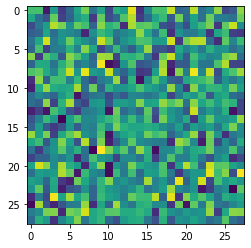

In [10]:
var_autoencoder = VAutoencoder(LATENT_DIM)
var_autoencoder = var_autoencoder.to(device)

im, _ = train_data[0]
im = im.to(device)

print(im.size())
y, _, _ = var_autoencoder(im.unsqueeze(0))

pix = y.squeeze().cpu().detach().numpy()

print(pix.shape)
plt.imshow(pix)
plt.show()

## define model / loss-function and optimizer    $\circ$    **vae**

In [11]:
BETA = 1

def loss_function(x, xhat, mu, sigma): 

    # print(torch.max(x), torch.min(x))
    # print(torch.max(xhat), torch.min(xhat))

    BCE = nn.functional.binary_cross_entropy(xhat, x, reduction='sum')
    KLD = -BETA * 0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

    return BCE + KLD

vae = VAutoencoder(LATENT_DIM)
vae.to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)

# print(model)

## train vae

In [12]:
training_loss = []

# number of epochs for training of the variational version 
NUM_EPOCHS = 50
print('starting training vae...')

for epoch in range(NUM_EPOCHS): 
    
    epoch_loss = 0.0 
    for batch in train_dataloader:
        im, _ = batch
        im = im.to(device)
        
        output, mu, sigma = vae(im)
        
        loss = loss_function(im, output, mu, sigma)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss.item()*im.size(0)
    
    epoch_loss = epoch_loss / len(train_dataloader)
    training_loss.append(epoch_loss)
    print(f'epoch {epoch+1} loss: {epoch_loss:.3f}')

starting training vae...
epoch 1 loss: 32231600.785
epoch 2 loss: 27581128.965
epoch 3 loss: 23778889.969
epoch 4 loss: 23234107.536
epoch 5 loss: 19629840.415
epoch 6 loss: 19061274.266
epoch 7 loss: 17450718.649
epoch 8 loss: 16164870.739
epoch 9 loss: 15306581.588
epoch 10 loss: 16215497.433
epoch 11 loss: 14641152.106
epoch 12 loss: 14188383.805
epoch 13 loss: 13652514.802
epoch 14 loss: 14970610.810
epoch 15 loss: 13928362.665
epoch 16 loss: 13118280.408
epoch 17 loss: 12914511.391
epoch 18 loss: 12648551.548
epoch 19 loss: 13362260.631
epoch 20 loss: 12458732.632
epoch 21 loss: 14138082.165
epoch 22 loss: 14648416.175
epoch 23 loss: 12497150.743
epoch 24 loss: 12546200.868
epoch 25 loss: 12093883.671
epoch 26 loss: 12293891.337
epoch 27 loss: 11914326.840
epoch 28 loss: 12339658.591
epoch 29 loss: 13720066.009
epoch 30 loss: 12372043.522
epoch 31 loss: 12218455.583
epoch 32 loss: 12057940.993
epoch 33 loss: 12062389.928
epoch 34 loss: 12199156.814
epoch 35 loss: 11674857.612
epoc

## testing trained vae

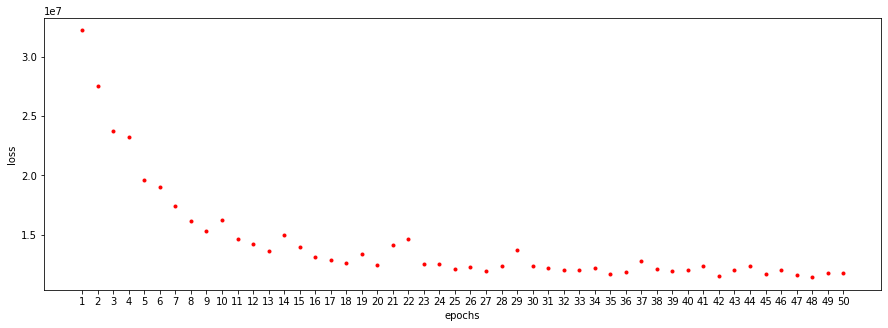

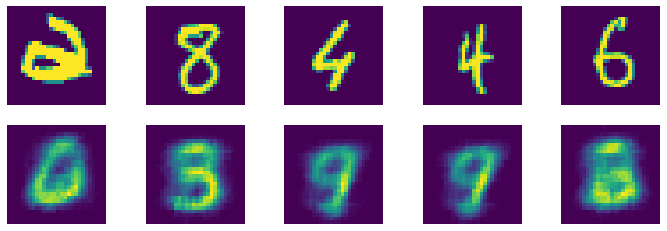

In [13]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(range(1, NUM_EPOCHS + 1), training_loss, 'r.')
plt.xticks(range(1, NUM_EPOCHS + 1 ))
plt.xlabel('epochs')
plt.ylabel('loss')

fig, axa = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,4))

for j in range(5): 
    pix = []
    im, _ = test_data[np.random.randint(0, len(test_data))]
    pix.append(im.squeeze().cpu().detach().numpy())
    y = model(im.to(device).unsqueeze(0))
    pix.append(y.squeeze().cpu().detach().numpy())
    
    for i in range(2):
        axa[i][j].imshow(pix[i])
        axa[i,j].axis('off')

## generating images with an instance of VDecoder

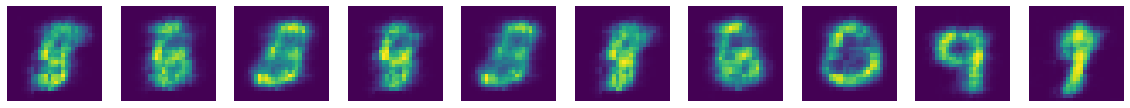

In [14]:
fig, axa = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20, 2))

for i in range(10):
    z = np.random.randn(LATENT_DIM)*np.random.randint(1, 4)
    z = torch.Tensor(z).to(device)
    pix = vae.vdecoder(z)
    axa[i].imshow(pix.squeeze().detach().cpu().numpy())
    axa[i].axis('off')

## plotting latent distribution

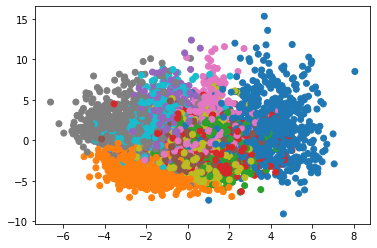

In [15]:
PLOT_BATCHES = 30

for i, (x, y) in enumerate(train_dataloader):
        z, _, _ = vae.vencoder(x.to(device))
        z = z.detach().cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > PLOT_BATCHES:
                break

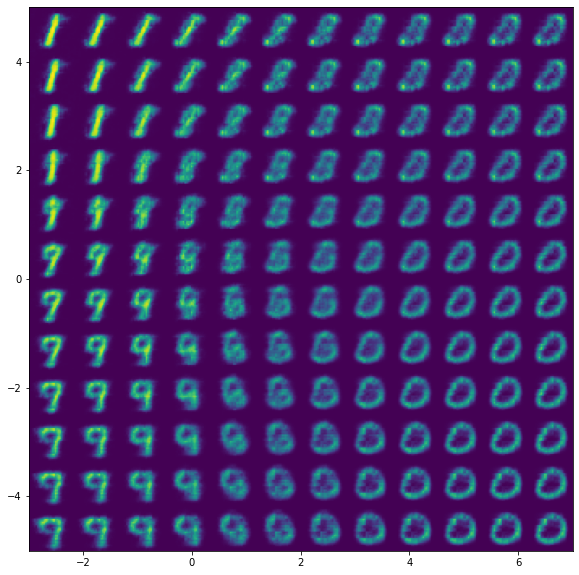

In [16]:
r0=(-3, 7)
r1=(-5, 5)
n=12

w = 28
img = np.zeros((n*w, n*w))

for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]]).to(device)
        x_hat = vae.vdecoder(z)
        x_hat = x_hat.reshape(28, 28).detach().cpu().numpy()
        img[i*w:(i+1)*w, j*w:(j+1)*w] = x_hat
plt.figure(figsize = (10,10))

plt.imshow(img, extent=[*r0, *r1])

# Conditional Variational Autoencoder

## CVEnocder, CVDecoder and CVAutoencoder classes

In [17]:
class CVEncoder(nn.Module):
    def __init__(self, latent_dim=1):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.fc0 = nn.Linear(28*28+10, 28*28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.fc_mean = nn.Linear(32*7*7, self.latent_dim)
        self.fc_std = nn.Linear(32*7*7, self.latent_dim)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, input, c):
        # fuse sample with labels
        x = self.fc0(torch.cat([input, c], 1))
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 32*7*7)
        mu = self.fc_mean(x)
        sigma = self.fc_std(x)
        z = self.reparametrization(mu, sigma)
        return z, mu, sigma
    
    def reparametrization(self, mu, sigma):
        if self.training: 
            r = torch.normal(0, 1, size=sigma.size()).to(device)
            z = mu + sigma * r
        else: z = mu
        return z
    
    
class CVDecoder(nn.Module):
    def __init__(self, latent_dim=1):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.fc0 = nn.Linear(self.latent_dim + 10, 16*7*7)
        self.fc1 = nn.Linear(16*7*7, 32*7*7)
        self.bn_fc = nn.BatchNorm2d(32)
        
        self.t_conv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)

        self.t_conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, padding=0, stride=2)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z, c):
        x = self.fc0(torch.cat([z, c], 1))
        x = self.relu(x)
        x = self.fc1(x)
        x = x.view(-1, 32, 7, 7)
        x = self.bn_fc(x)
        x = self.relu(x)
        
        x = self.t_conv1(x)
        x = self.relu(x)

        x = self.t_conv2(x)
        x = self.sigmoid(x)


        return x

class CVAutoencoder(nn.Module):
    def __init__(self, latent_dim=1):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.cvencoder = CVEncoder(latent_dim)
        self.cvdecoder = CVDecoder(latent_dim)
        
    def forward(self, input, c): 
        x = input.view(-1, 28*28)
        z, mu, sigma = self.cvencoder(x, c)
        x = self.cvdecoder(z, c)
        return x, mu, sigma

## define model / loss-function and optimizer    $\circ$    **cvae**

In [18]:
LEARNING_R = 1e-3
BETA = 1

def loss_function(x, xhat, mu, sigma): 

    # print(torch.max(x), torch.min(x))
    # print(torch.max(xhat), torch.min(xhat))

    BCE = nn.functional.binary_cross_entropy(xhat, x, reduction='sum')
    KLD = -BETA * 0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

    return BCE + KLD

cvae = CVAutoencoder()
cvae.to(device)

optimizer = torch.optim.Adam(cvae.parameters(), lr=LEARNING_R)


## train cvae

In [19]:
training_loss = []

# number of epochs for training of the variational version 
N_EPOCHS = 30
print('starting training cvae...')

for epoch in range(N_EPOCHS): 
    
    epoch_loss = 0.0 
    for batch in train_dataloader:
        im, label = batch
        im, label = im.to(device), label.to(device)
        y = torch.nn.functional.one_hot(label, num_classes=10)
        output, mu, sigma = cvae(im, y)
        
        loss = loss_function(im, output, mu, sigma)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += loss.item()*im.size(0)
    
    epoch_loss = epoch_loss / len(train_dataloader)
    training_loss.append(epoch_loss)
    print(f'epoch {epoch+1} loss: {epoch_loss:.3f}')

starting training cvae...
epoch 1 loss: 15293725.711
epoch 2 loss: 11530654.788
epoch 3 loss: 10860773.510
epoch 4 loss: 10237719.349
epoch 5 loss: 10046455.410
epoch 6 loss: 9938925.296
epoch 7 loss: 9870137.902
epoch 8 loss: 9812685.534
epoch 9 loss: 9761021.456
epoch 10 loss: 9726063.983
epoch 11 loss: 9693339.193
epoch 12 loss: 9816624.352
epoch 13 loss: 9790778.558
epoch 14 loss: 9633688.052
epoch 15 loss: 10184198.489
epoch 16 loss: 10105420.305
epoch 17 loss: 10443980.671
epoch 18 loss: 10156618.908
epoch 19 loss: 9899043.988
epoch 20 loss: 9906726.484
epoch 21 loss: 9773794.218
epoch 22 loss: 9816099.762
epoch 23 loss: 10906425.077
epoch 24 loss: 10091016.641
epoch 25 loss: 9906791.500
epoch 26 loss: 9937551.424
epoch 27 loss: 9888084.103
epoch 28 loss: 9784712.508
epoch 29 loss: 10972611.993
epoch 30 loss: 10382722.065


## generating images with CVDecoder

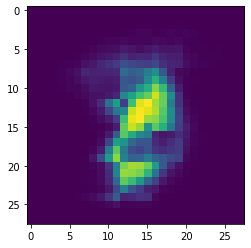

In [20]:
with torch.no_grad():
    c = torch.eye(10, 10).to(device)
    sample = torch.randn(10, 20).to(device)
    sample = cvae.cvdecoder(sample, c).cpu()
    
    plt.imshow(sample[5].view(28, 28))

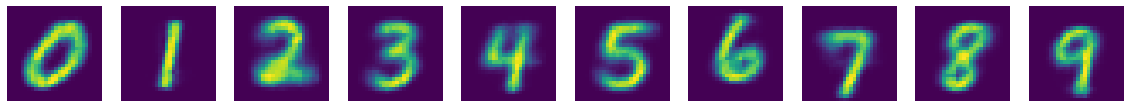

In [21]:

classes = torch.Tensor(list(range(10))).to(device)
y = torch.nn.functional.one_hot(classes.to(torch.int64), num_classes=10)
z = torch.randn(10,1).to(device)

gpix = cvae.cvdecoder(z, y)


plt.figure(figsize = (20,2))
for i in range(10): 

      plt.subplot(1, 10, i+1)
      plt.axis('off')
      plt.imshow(gpix[i].detach().squeeze().cpu().numpy())
plt.show()

## plotting latent distribution & sample gird

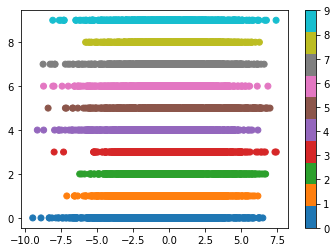

In [22]:
PLOT_BATCHES = 30

for i, batch in enumerate(train_dataloader):
    x, y = batch
    x, y = x.to(device), y.to(device)
    x = x.view(-1, 28*28)
    y_hot = torch.nn.functional.one_hot(y, num_classes=10)
    z, _, _ = cvae.cvencoder(x, y_hot)
    z = z.cpu().detach().numpy()
    plt.scatter(z[:, 0], y.cpu(), c=y.cpu(), cmap='tab10')
    if i > PLOT_BATCHES:
        plt.colorbar()
        plt.show()
        break

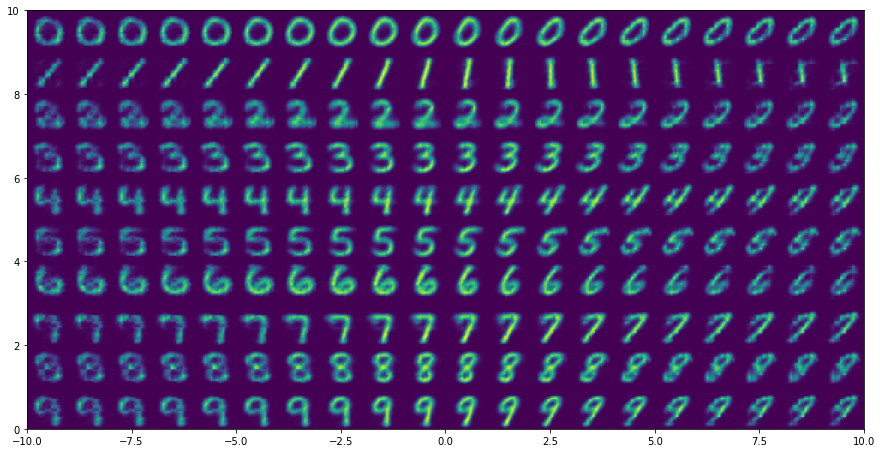

In [23]:
r0=(0, 9)
r1=(-10, 10)
n=10
m=20

w = 28
img = np.zeros((n*w, m*w))

for i, y in enumerate(np.linspace(*r0, n)):
    for j, x in enumerate(np.linspace(*r1, m)):
        y = torch.Tensor([y, ])
        y = y.to(device)
        y_hot = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=10)
        z = torch.Tensor(np.array([x])).to(device)
        z = torch.unsqueeze(z, 0)
        x_hat = cvae.cvdecoder(z, y_hot)
        x_hat = x_hat.reshape(28, 28).detach().cpu().numpy()
        img[i*w:(i+1)*w, j*w:(j+1)*w] = x_hat

plt.figure(figsize = (15,30))

plt.imshow(img, extent=[*r1, 0, 10])